# **💁🏻🗨️💁🏻‍♂️안개 예측 EDA code**
> **안개량 예측** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 대회에서는 최대 10명이 참여할 수 있는 기상청 주관 날씨 빅데이터 경진대회 입니다.     
> 주어진 데이터를 활용하여 안개 상태의 구간을 예측할 수 있는 모델을 만드는 것이 목표입니다!

# Contents  
  
- 필요한 라이브러리 설치  
- 데이터 불러오기  
- 사용할 변수 선택하기
- 모델링
- 추론
- 결과 저장하기
- 결과 그 이후

### 1. 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [1]:
# basic
import os, random
import pandas as pd
import numpy as np
import torch

# model
from catboost import CatBoostClassifier, Pool

# eval metric
from sklearn.metrics import confusion_matrix

# graph
import shap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# random sampling
from sklearn.model_selection import train_test_split

# optuna tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

### 2. 데이터 불러오기
- 제공된 데이터를 불러옵니다.

> - year : 년도
> - month : 월
> - day : 일
> - hour : 시간
> - minute : 분(10분 단위)
> - stn_id : 지점 번호
> - ws10_deg : 10분 평균 풍향, deg
> - ws10_ms : 10분 평균 풍속, m/s
> - ta : 1분 평균 기온 10분 주기, 섭씨
> - re : 강수 유무 0:무강수, 1:강수
> - hm : 1분 평균 상대 습도 10분 주기, %
> - sun10 : 1분 일사량 10분 단위 합계, MJ
> - ts : 1분 평균 지면온도 10분 주기, 섭씨

- test 없는 데이터 값
> - vis1 : 1분 평균 시정 10분 주기, m
> - class : 시정 구간

시정 구간은 다음과 같다.
- 0초과 200미만 : 1
- 200이상 500미만 : 2
- 500이상 1000미만 : 3
- 1000이상 : 4
- 4번은 맞춰도 스코어가 증가하진 않지만 틀리면 감점

In [3]:
# load makes data
train = pd.read_csv('../data/train_preprocessed_data.csv')
test = pd.read_csv('../data/test_preprocessed_data.csv')

#### 2-1. 함수 만들기

In [4]:
# evaluation
def csi_score(true, pred, exceptcol = 0):

    # confusion matrix 만들기
    CONFUSION_MATRIX = pd.crosstab(true, pred).values

    # 차원의 수
    n, m = CONFUSION_MATRIX.shape

    # 계산하여 받을 값
    H = 0
    F = 0
    M = 0
    for i in range(n):
        for j in range(m):
            if i == j == exceptcol:
                continue
            elif i == j:
                H += CONFUSION_MATRIX[i][j]
            elif j != exceptcol:
                F += CONFUSION_MATRIX[i][j]
            elif i != exceptcol:
                M += CONFUSION_MATRIX[i][j]

    return H / (H + F + M)

Accuracy 매트릭에서 마지막 항 점수는 반영되지 않게 처리

In [5]:
# custom metric
class CSIMetric(object):

    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        best_class = np.zeros(len(approxes[0]))
        
        for i in range(len(approxes[0])):
            approx_i = [approxes[j][i] for j in range(len(approxes))]
            best_class[i] = np.argmax(np.array(approx_i))
        
        accuracy_sum = 0
        weight_sum = 0 

        for i in range(len(target)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            if best_class[i] != '4' or best_class[i] != 4:
                accuracy_sum += w * (best_class[i] == target[i])

        return accuracy_sum, weight_sum

### 3. 사용할 변수 선택하기

데이터에서 필요한 칼럼을 선택하여 적용하기로 한다.

In [6]:
# label 선택하기
use_label_x = ['hm', 're', 'sun10', 'ta', 'ts', 'ws10_deg', 'ws10_ms', 'ground',
       'dew_point', 'sin_time', 'cos_time', 'sin_month', 'cos_month', 'diff_air-dew', 'diff_ts-dew', 'fog_risk'
       # 'make_copyfog', 'make_irufog', 'make_mountfog', 'make_gimfog', 'retain_fog', 'upclass_fog'
       ]

use_label_y = ['class']

In [7]:
# test set 구성하기
test_x = test[use_label_x]

In [8]:
# 랜덤 샘플링하게 뽑자
train_x, valid_x, train_y, valid_y = train_test_split(train[use_label_x],
                                                      train[use_label_y],
                                                      test_size = 0.2,
                                                      random_state = 42)

In [15]:
# 범주형 피처
cat_features = [
    're', 'ground'#, # 'A', 'B', 'C', 'D',
    #'make_copyfog', 'make_irufog', 'make_mountfog', 'make_gimfog', 'retain_fog', 'upclass_fog'
]

### 4. 모델링
Catboost는 시계열 데이터 또는 범주형 데이터에 좋은 성능을 가져오는 모델로 알려져 있기 때문에 적용하도록 한다.

timeseries split을 활용해 적합을 진행해보도록 한다.

In [16]:
# class weights
class_weights = [30, 30, 30, 1]

In [17]:
# # random sampler
# sampler = TPESampler(seed=10)

# # define function
# def objective(trial):

#     cbrm_param = {
#         "objective": "MultiClass",
#         # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bernoulli", "Poisson"]
#         ),
#         'iterations':trial.suggest_int("iterations", 1000, 5000),
#         'learning_rate' : trial.suggest_uniform('learning_rate', 0.01, 1),
#         'reg_lambda': trial.suggest_uniform('reg_lambda', 1e-5, 100),
#         'subsample': trial.suggest_uniform('subsample', 0 ,1),
#         'random_strength': trial.suggest_uniform('random_strength', 10, 50),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 30, 100),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
#         "boosting_type": 'Plain',
#         'cat_features':cat_features,
#         'one_hot_max_size':4,
#         'eval_metric':'MultiClass',
#         'class_weights':class_weights,
#         'random_state':42,
#         'task_type':'GPU',
#     }

#     # bootstrap 마다 다른 params 추가
#     if cbrm_param["bootstrap_type"] == "Bayesian":
#         cbrm_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif cbrm_param["bootstrap_type"] == "Bernoulli":
#         cbrm_param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     # Generate model
#     cb = CatBoostClassifier(**cbrm_param)
#     # fit the model

#     cb.fit(
#         train_x, train_y,
#         eval_set = [(valid_x, valid_y)],
#         early_stopping_rounds = 50,
#         verbose = 100
#     )
                           
#     # 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
#     CSI = csi_score(np.reshape(valid_y.values, -1), np.reshape(cb.predict(valid_x), -1), 3)
#     return CSI

# optuna_cbrm = optuna.create_study(direction='maximize', sampler=sampler)
# optuna_cbrm.optimize(objective, n_trials = 50)

In [18]:
# optuna_cbrm.best_params

# {'depth': 12,
#  'bootstrap_type': 'Bernoulli',
#  'iterations': 2178,
#  'learning_rate': 0.03978756063905378,
#  'reg_lambda': 95.06719663989301,
#  'subsample': 0.980507422817941,
#  'random_strength': 42.091243716971206,
#  'min_data_in_leaf': 61,
#  'leaf_estimation_iterations': 1}

In [19]:
# best parameter - 웬만하면 이 파라미터로 계속 진행할 예정
# cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = {'objective': 'MultiClass',
                    'depth': 12, 
                    'boosting_type': 'Plain', 
                    'bootstrap_type': 'Bernoulli', 
                    'iterations': 2178, 
                    'learning_rate': 0.03978756063905378, 
                    'reg_lambda': 95.06719663989301, 
                    'subsample': 0.980507422817941, 
                    'random_strength': 42.091243716971206, 
                    'min_data_in_leaf': 61, 
                    'leaf_estimation_iterations': 1,
                    'cat_features':cat_features,
                    'one_hot_max_size':4,
                    'eval_metric': 'MultiClass',
                    'class_weights': class_weights,
                    'random_state':42,
                    'task_type':'GPU',
}
# print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

In [20]:
# 파라미터 구성
cb_best = CatBoostClassifier(**cbrm_trial_params, verbose = 100)

# fit the model
cb_best.fit(
    train_x, train_y,
    eval_set = [(valid_x, valid_y)],
    early_stopping_rounds = 50,
    verbose = 100
)

0:	learn: 1.3122437	test: 1.3123755	best: 1.3123755 (0)	total: 467ms	remaining: 16m 57s
100:	learn: 0.4084980	test: 0.4286084	best: 0.4286084 (100)	total: 1m 45s	remaining: 36m 12s
200:	learn: 0.3742982	test: 0.4001061	best: 0.4001033 (197)	total: 3m 29s	remaining: 34m 24s
300:	learn: 0.3704568	test: 0.3971611	best: 0.3971611 (300)	total: 4m 27s	remaining: 27m 45s
400:	learn: 0.3568478	test: 0.3863868	best: 0.3863868 (400)	total: 5m 52s	remaining: 26m
500:	learn: 0.3127363	test: 0.3578464	best: 0.3578464 (500)	total: 9m 52s	remaining: 33m 1s
600:	learn: 0.2850882	test: 0.3434912	best: 0.3434912 (600)	total: 13m 56s	remaining: 36m 33s
700:	learn: 0.2657734	test: 0.3347568	best: 0.3347568 (700)	total: 17m 59s	remaining: 37m 55s
800:	learn: 0.2492539	test: 0.3283496	best: 0.3283496 (800)	total: 21m 57s	remaining: 37m 44s
900:	learn: 0.2359368	test: 0.3232838	best: 0.3232838 (900)	total: 25m 49s	remaining: 36m 35s
1000:	learn: 0.2285985	test: 0.3207901	best: 0.3207858 (994)	total: 29m 12s	

### 5. 추론

- train, valid를 모두 포함한 데이터를 통해 전체적으로 학습을 다시 진행한 다음 test를 적합하도록 한다.  
- 이름을 꼭 ID에 맞도록 설정해 주어야 한다.

In [21]:
# # predict
# pred_list = []

# # 각 모델별 예측값 가져오기
# for i, model in enumerate(models):
#     pred_list.append(model.predict_proba(test_x))

# # 확률값 평균내기
# pred_proba = np.mean(pred_list, axis = 0)

In [22]:
# 예측값
pred_proba = cb_best.predict_proba(test_x)

In [23]:
# 예측값 가져오기
pred_class = np.argmax(pred_proba, axis = 1) + 1

In [24]:
np.unique(pred_class, return_counts=True)

(array([1, 2, 3, 4], dtype=int64),
 array([   879,   2795,   2395, 256731], dtype=int64))

### 6. 추론결과 확인하기

- 생성한 모델에서 어떤 변수가 가장 영향을 주는지 확인할 필요가 있다.

In [25]:
# 분석 결과 feature importance 확인
explainer = shap.TreeExplainer(cb_best)
shap_values = explainer.shap_values(test_x)
class_names = [1, 2, 3, 4]


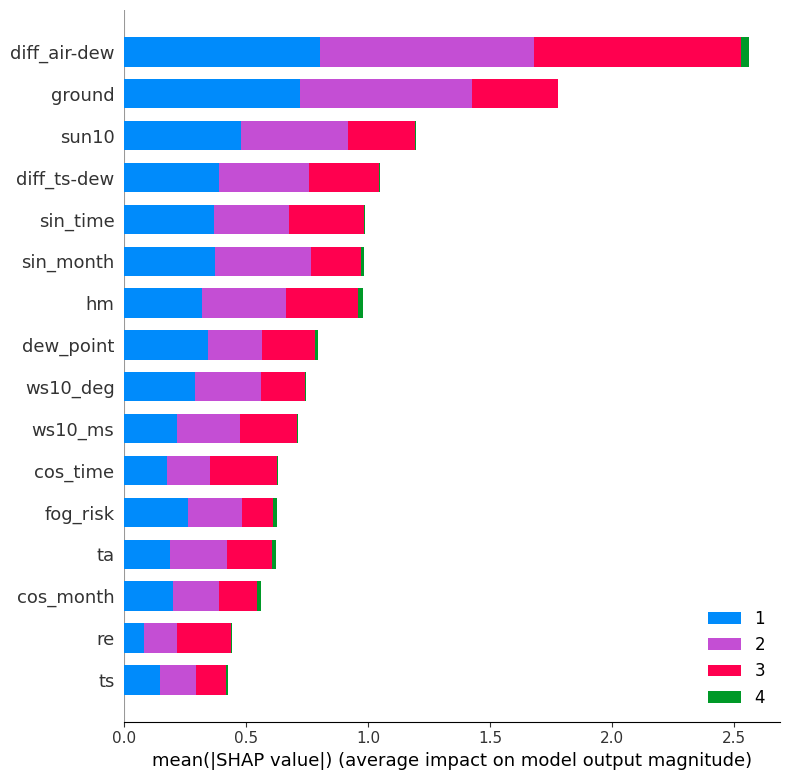

--------------------------------------------------------------------------------


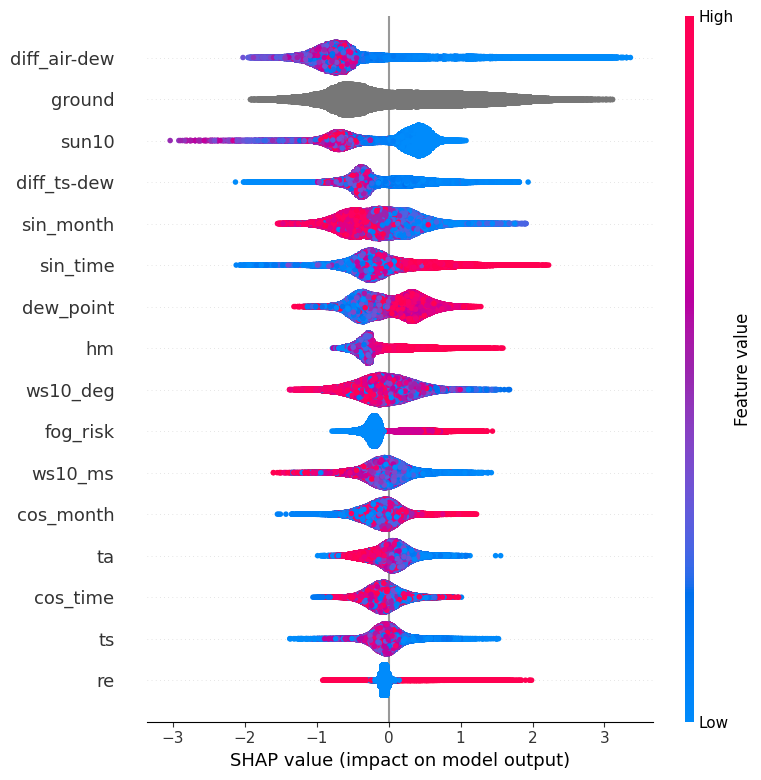

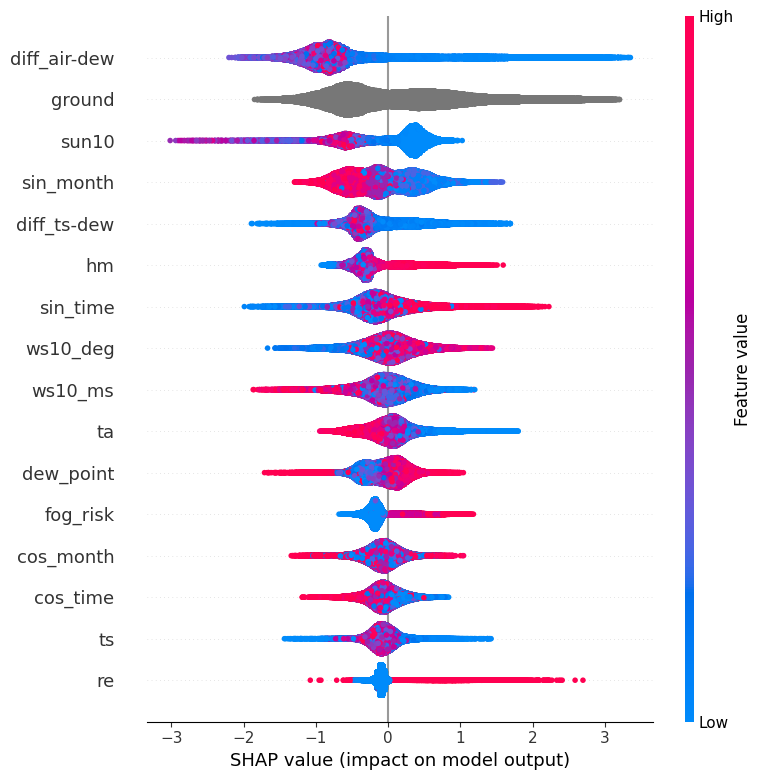

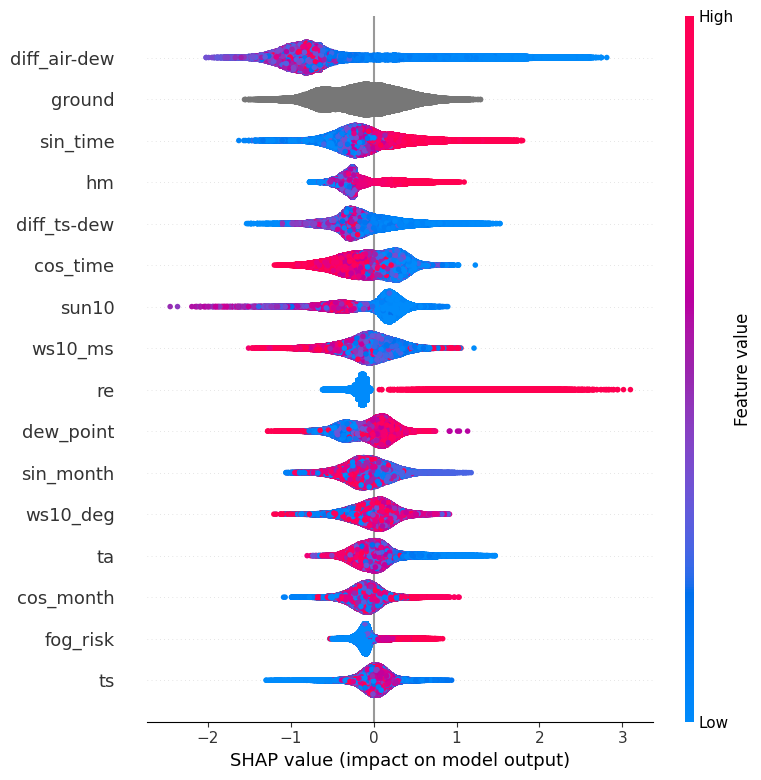

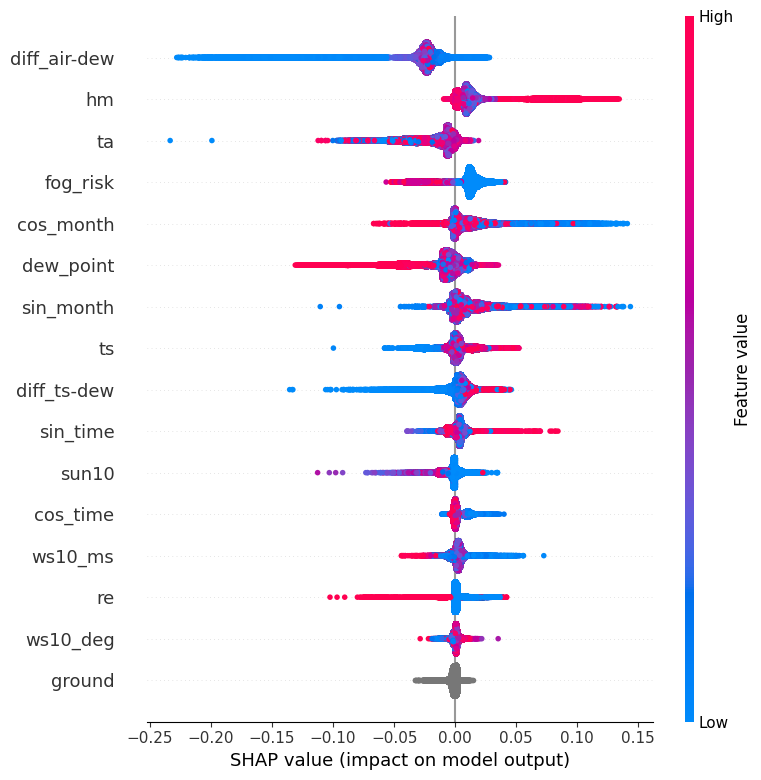

In [26]:
# feature importance plot
shap.summary_plot(shap_values, train_x, plot_type="bar",
                class_names= class_names, feature_names = train_x.columns)

print("-" * 80)
# visualize 
shap.summary_plot(shap_values[0], test_x)
shap.summary_plot(shap_values[1], test_x)
shap.summary_plot(shap_values[2], test_x)
shap.summary_plot(shap_values[3], test_x)

valid set을 통해 확인해보기

In [37]:
# # predict
# pred_list2 = []

# # 각 모델별 예측값 가져오기
# for i, model in enumerate(models):
#     pred_list2.append(model.predict_proba(train_x))

In [72]:
# 확률값 평균내기
# pred_proba2 = np.mean(pred_list2, axis = 0)
pred_proba2 = cb_best.predict_proba(train[use_label_x])

In [76]:
# 예측값 가져오기
pred_class2 = np.argmax(pred_proba2, axis = 1) + 1

In [77]:
np.unique(pred_class2, return_counts=True)

(array([1, 2, 3, 4], dtype=int64),
 array([  13225,   25512,   33872, 3083851], dtype=int64))

In [78]:
np.unique(train[use_label_y], return_counts=True)

(array([1, 2, 3, 4], dtype=int64),
 array([   7687,   11592,   12207, 3124974], dtype=int64))

In [81]:
pd.crosstab(train['class'], pred_class2)

col_0,1,2,3,4
class,,,,
1,6454,894,107,232
2,586,9707,693,606
3,141,1174,9351,1541
4,6044,13737,23721,3081472


In [83]:
# csi score
(6454 + 9707 + 9351)/ (len(train) - 3081472)

0.3402144343094895

In [84]:
# pred
train['pred'] = pred_class2

In [89]:
pd.crosstab(train[train['ground'] == 'E']['class'], train[train['ground'] == 'E']['pred'])

pred,1,2,3,4
class,,,,
1,775,58,10,6
2,74,627,74,27
3,17,49,892,139
4,672,609,2522,466918


In [97]:
# 1시간 미만만 모아서
fig = px.histogram(train[train['class'] == 1],
                  x = "fog_risk",
                  color = 'pred',
                  barmode = "group")

fig.update_layout(title_text="시간별 안개발생 종료 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

### 7. 제출물 저장하기

In [31]:
# 제출물 불러오기
submission = pd.read_csv('../Data/fog_test.csv')

In [32]:
# 앞에 필요없는 열 버리기
submission.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [33]:
# 대입해서 저장하기
submission['fog_test.class'] = pred_class

In [34]:
# 저장하기
submission.to_csv('../data/240253.csv', index = False)